# Statistics 504 - Fall 2015
## Title: " Exploring landslide severity across Washington using machine learning techniques"
### Class Project Proposal
### Erich Seamon
### erichs@uidaho.edu
### http://webpages.uidaho.edu/erichs


# Introduction and Overview of Dataset


The premise of this research will be to develop a set of models that effectively predict landslide severity, within the state of Washington, using geomorphic and landscape-driven feature variables, such as geology, soils, gradient, land-use, and previous landslide type.   <br>

Previous work by Ardizzone et al (2002), Ayalew and Yamagishi (2005), Ohlmacher and David (2003), all used logistical regression as a classifer method for landslide analysis. To expand upon this work, this project will evaluate several differing models to predict landslide severity:<br>

- logistical regression <br> 
- naive bayes <br>
- knn <br>
- random forest <br>
- decision tree <br>
- bagged decision tree <br>
- bagged random forest <br>


Under this approach, landslide explanatory variables will be trained on a training data set of an observed landslide locations, with thematic data such as morphometric attributes (gradient, slope morphology) as well as information on geology and landuse. 

The eventual goal will be to create a landslide model that is capable of returning a predictive result in the form of a geographic mapspace (essentially a prediction for each pixel).

## Data Sources

2007 and 2008 Landslide data for the state of Washington, containing over 52,000 observations, was accessed from the Washington Department of Natural Recreation (WA DNR). The data was provided as a downloadable .gdb file (geodatabase file).

http://www.dnr.wa.gov/publications/ger_portal_landslides_landforms.zip


## Data Transformation Before Analysis

The data was imported as a csv file - that was derived from the provided geodatabase file.  This csv file contained over 52,000 observations, with latitude and longitude included as well.  The csv file was transformed into a a pandas data frame, with text based categorical fields transformed to numeric values.  From this pandas data frame, our feature columns (X) and our response variable (y) were derived.

From the 52,000+ landslide observations, the number was reduced to:

#### 12,241

After eliminating records with NANs and other missing values needed for the analysis.

In [1]:
import PIL
import os,sys
import numpy as np
from PIL import Image
from urllib2 import urlopen
basewidth = 1100
img = Image.open(urlopen("http://webpages.uidaho.edu/erichs/dmine-data/Landslide_data_flow.jpg"))
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
img.save("landslide_information_flow_refined.jpg")

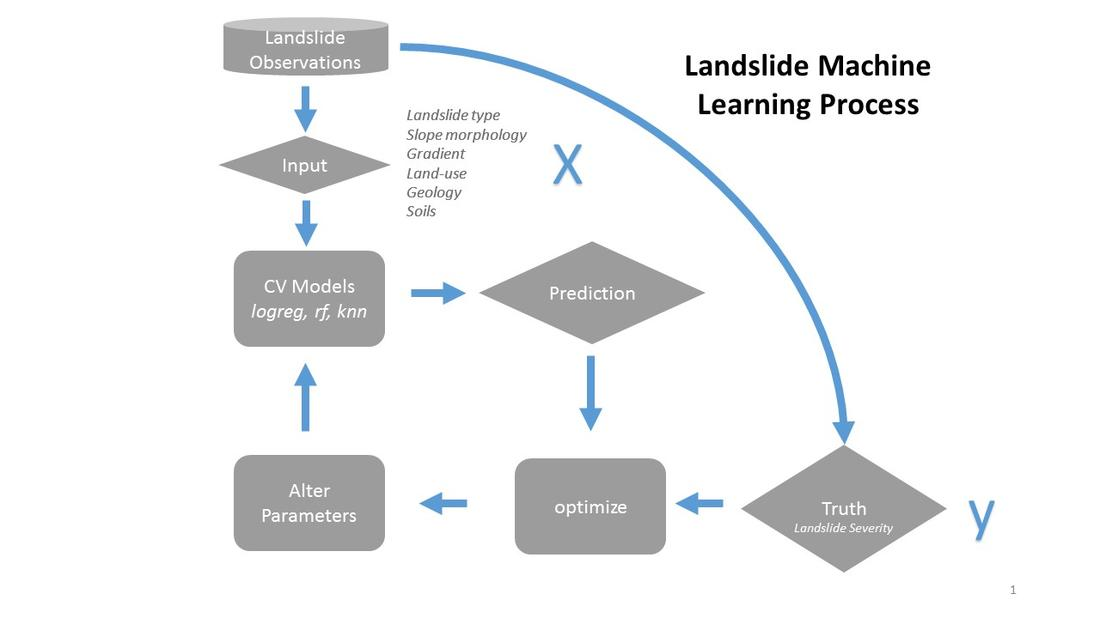

In [2]:
import os,sys
from PIL import Image
jpgfile = Image.open("landslide_information_flow_refined.jpg")
jpgfile

## Response and Feature Variables:

### Morphometric feature variables:

1) Slope Morphology Shape (SLOPE_MORP)   - Planar, Convex, Concave, etc. <br>
2) Land Use (LAND_USE)   - Forestry, Road/Rail/Trail, Undistubed, Urban Development <br>
3) Landslide Type (LANDSLIDE1)   - Debris Flows, Debris Slides and Avalanches, Shallow Undifferentiated, etc.<br>
4) Gradient (GRADIENT_D - transformed to gradient_cat)  - gradient of the landslide location, in degrees.<br>
5) Geology (GEOLOGIC_1) - geologic unit <br>
6) Soils (reacch_soi) - soils <br>

### Response Variable:

1) Landslide Severity (LANDSLID_3) - Low (0), Med (1) or High (2). <br>

Multiclass classification means a classification task with more than two classes. Multiclass classification makes the assumption that each sample is assigned to one and only one label.

# Preliminary Data Import and Analysis

In [3]:
import matplotlib
%matplotlib nbagg

from pyproj import Proj
import StringIO
from pandas import DataFrame
import pandas as pd
import seaborn as sns
import pydot
from IPython.display import Image

from urllib2 import Request, urlopen
import json
from pandas.io.json import json_normalize
import numpy
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
%load_ext memory_profiler

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Import csv file for all 52,000+WA landslides

In [4]:
import csv

In [5]:
walandslides_all = pd.read_csv('/git/data/landslides/WALandslides_export4.csv')

In [6]:
#walandslides = pd.read_csv('/git/data/landslides/WALandslides_geol4subset.csv')

In [12]:
walandslides = pd.read_csv('http://webpages.uidaho.edu/erichs/dmine-data/WALandslides.csv')

## Table of all values for initial landslide dataset

In [ ]:
walandslides.

In [15]:
walandslides.LANDSLIDE1.value_counts()

Shallow undifferentiated       18232
Deep-seated                     8719
Unknown                         8602
Debris flow                     7244
Debris slide and avalanches     4977
Deep-seated earthflow           2716
Block fall or topple             730
Deep-seated translational        465
Deep-seated composite            336
Deep-seated rotational           275
Hyperconcentrated flows           91
Megalandslide/ Sturzstrom          1
dtype: int64

In [8]:
walandslides_allxy = [walandslides_all.OBJECTID, walandslides_all.POINT_X, walandslides_all.POINT_Y]
walandslides_allxy = pd.DataFrame(walandslides_allxy)
walandslides_allxy = walandslides_allxy.transpose()
walandslides = pd.DataFrame(walandslides)
walandslides = pd.merge(walandslides_allxy, walandslides, on='OBJECTID', how='outer')

## Set landslide type as numeric

In [9]:
stringh1 = set(walandslides.LANDSLIDE1)
J = list(stringh1)
J2 = list(range(1, 106))

In [10]:
i2 = iter(J)
j2 = iter(J2)
k2 = list(zip(i2, j2))
kdict2 = dict(k2)
kdict2.values()
walandslides['LANDSLIDE1'].replace(kdict2, inplace=True)
#print walandslides.LANDSLIDE1

In [11]:
walandslides.LANDSLIDE1

0         3
1        12
2         3
3         3
4        12
5         3
6        12
7        12
8         3
9         3
10        3
11       11
12       11
13       12
14       11
15       12
16       12
17       12
18       11
19        3
20        3
21        3
22        3
23       11
24        3
25       11
26        3
27        3
28        3
29       12
         ..
52779    12
52780    12
52781     6
52782    10
52783    12
52784    12
52785    11
52786    10
52787    12
52788     6
52789    12
52790    12
52791    11
52792    12
52793    10
52794    12
52795     6
52796    12
52797     6
52798     3
52799    11
52800    10
52801    11
52802    13
52803     6
52804     6
52805    10
52806    12
52807    12
52808    12
Name: LANDSLIDE1, dtype: int64

## Convert categorical text columns to categorical numerical

In [17]:
walandslides['DATA_CONFI'] = walandslides.DATA_CONFI.map({'Low':0, 'Moderate-High':1})
walandslides['SLOPE_MORP'] = walandslides.SLOPE_MORP.map({'Planar':0, 'Concave-Planar':1, 'Concave, convergent':2, 'Planar-Concave':3, 'Planar-convex':4})
walandslides['LANDSLID_3'] = walandslides.LANDSLID_3.map({'Questionable':0, 'Probable':1, 'Certain':2, 'Unknown':3})

## Reduce dataset by eliminating NANs, set feature columns for X

In [18]:
walandslides = walandslides[np.isfinite(walandslides['SLOPE_MORP'])]
walandslides = walandslides[np.isfinite(walandslides['LANDSLIDE1'])]
walandslides = walandslides[walandslides.LANDSLID_3 != 3]
walandslides = walandslides[walandslides.GRADIENT_D != 0]
feature_cols = ['gradient_cat', 'GEOLOGIC_1', 'reacch_soi', 'LAND_USE', 'LANDSLIDE1', 'SLOPE_MORP']

## Convert GRADIENT_D to categorical, using quantiles

In [19]:
labelz = ["1", "2", "3", "4", "5"]
gradient = pd.DataFrame(walandslides.GRADIENT_D)
gradient = pd.DataFrame(pd.qcut(walandslides.GRADIENT_D, 5, labels = labelz))
gradient.rename(columns={'GRADIENT_D':'gradient_cat'}, inplace=True)
walandslides = pd.concat([walandslides, gradient], axis=1, join_axes=[gradient.index])

## Plot the refined WA landslides (~12000 landslide observations)

<IPython.core.display.Javascript object>


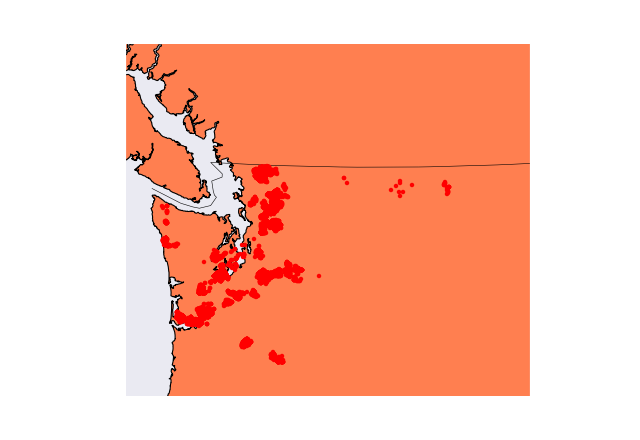

In [39]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg
my_map2 = Basemap(llcrnrlon=-125, llcrnrlat=45, urcrnrlon=-115, urcrnrlat=51, projection='tmerc', lat_1=33, lat_2=45,
     lon_0=-119, lat_0=45, resolution='h', area_thresh=10000)
my_map2.drawcoastlines()
my_map2.drawcountries()
my_map2.fillcontinents(color='coral')
lon2 = np.array(walandslides.POINT_X)
lat2 = np.array(walandslides.POINT_Y)
y2,x2 = my_map2(lon2, lat2)
my_map2.plot(y2,x2, 'ro', markersize=4, markeredgecolor = 'k')
plt.show()

## Final X and y - reduced to a size of 12241 observations

In [21]:
walandslides['LAND_USE'] = walandslides.LAND_USE.map({'Forestry related activities':0, 'Undisturbed':1, 'Unknown':2, 'Urban development':3, 'Road, railroad, trail':4})

In [22]:
X = walandslides[feature_cols]
y = walandslides.LANDSLID_3
y = pd.concat([y], axis=1)
X[:5]

,gradient_cat,GEOLOGIC_1,reacch_soi,LAND_USE,LANDSLIDE1,SLOPE_MORP
1,3,29787,55856,4,12,0
2,5,33552,55805,4,3,4
4,1,32784,55804,4,12,0
5,4,30800,55837,4,3,0
6,3,30800,55837,3,12,0


In [23]:
## - put X and y together for purposed of boxplots later
Xy = pd.concat([X, y], axis=1, join_axes=[X.index])

# Data Exploration

## Initial breakdown of gradient by degree (categorized)

In [24]:
gradient_pd = X['gradient_cat'].value_counts()
X['gradient_cat'].value_counts()

3    3044
2    2507
1    2464
5    2239
4    1987
dtype: int64

<IPython.core.display.Javascript object>


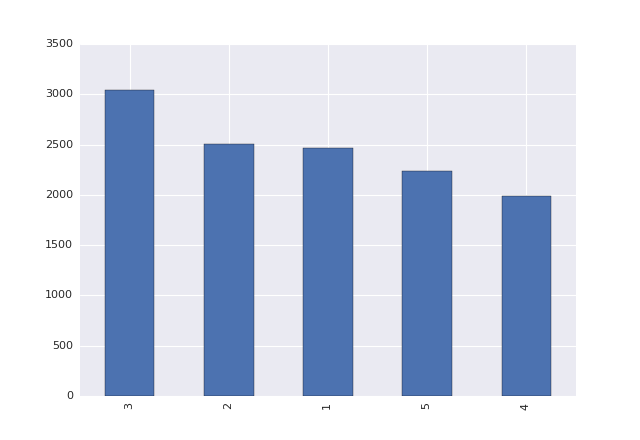

In [40]:
import matplotlib
%matplotlib nbagg
gradient_pd.plot(kind='bar');

### Initial breakdown of geology

In [26]:
geology_pd = X['GEOLOGIC_1'].value_counts()
geology_unique = pd.unique(X.GEOLOGIC_1.ravel())
geology_unique.shape

(907,)

<IPython.core.display.Javascript object>


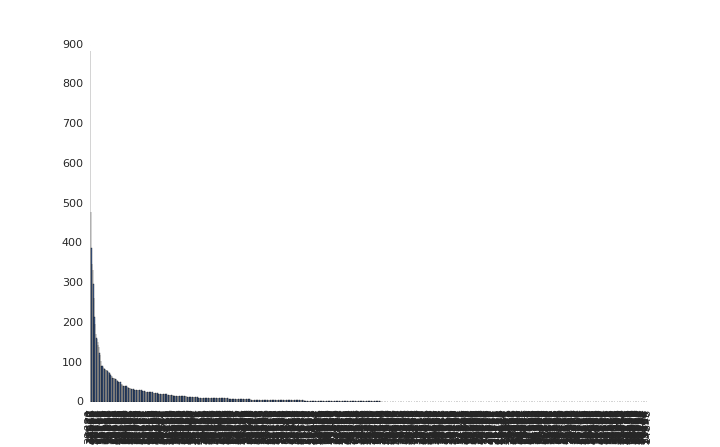

In [41]:
import matplotlib
%matplotlib nbagg
geology_pd.plot(kind='bar');

### Initial breakdown of soils

In [28]:
soils_pd = X['reacch_soi'].value_counts()
soils_unique = pd.unique(X.reacch_soi.ravel())
soils_unique.shape

(656,)

<IPython.core.display.Javascript object>


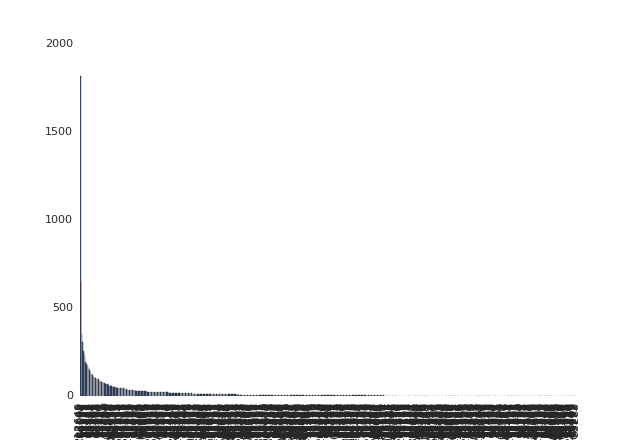

In [42]:
import matplotlib
%matplotlib nbagg
soils_pd.plot(kind='bar');

### Initial breakdown of slope morphology

In [30]:
slopemorp_pd = X['SLOPE_MORP'].value_counts()
X['SLOPE_MORP'].value_counts()

2    6526
0    5199
4     516
dtype: int64

<IPython.core.display.Javascript object>


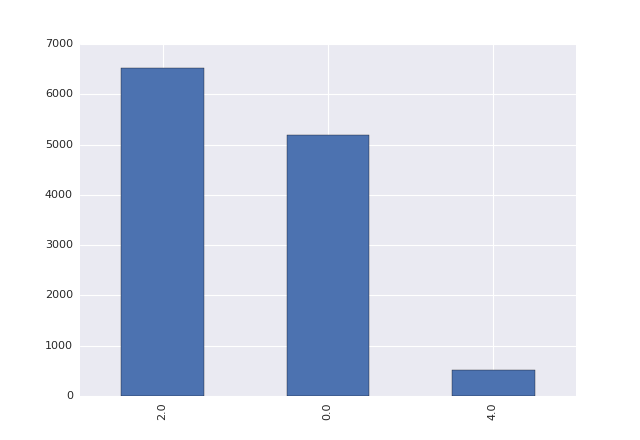

In [43]:
import matplotlib
%matplotlib nbagg
slopemorp_pd.plot(kind='bar');

### Initial breakdown of land use

In [32]:
landuse_pd = X['LAND_USE'].value_counts()
X['LAND_USE'].value_counts()

0    5981
2    3199
4    2479
1     529
3      53
dtype: int64

<IPython.core.display.Javascript object>


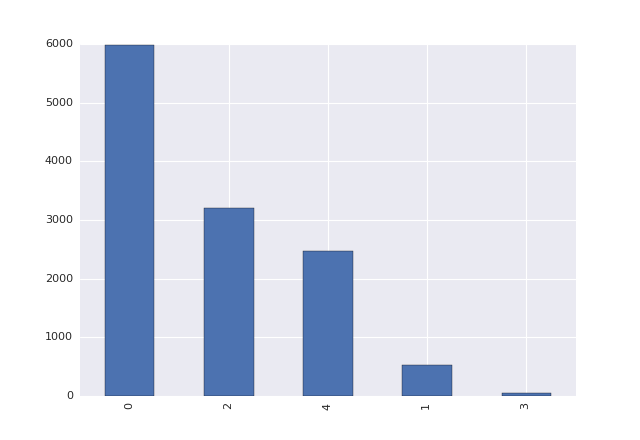

In [44]:
import matplotlib
%matplotlib nbagg
landuse_pd.plot(kind='bar');

### Initial breakdown of landslide type

In [34]:
landslidetype_pd = X['LANDSLIDE1'].value_counts()
X['LANDSLIDE1'].value_counts()

12    5496
11    2262
10    1913
3     1542
13     434
9      284
6      125
1      109
2       33
5       28
8       15
dtype: int64

<IPython.core.display.Javascript object>


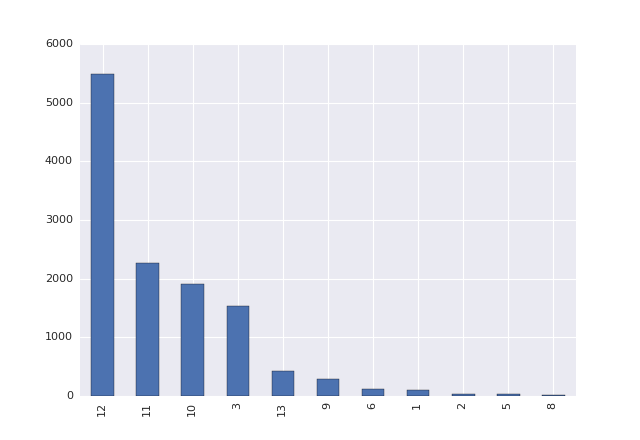

In [45]:
import matplotlib
%matplotlib nbagg
landslidetype_pd.plot(kind='bar');

### Response Variable - LANDSLID_3 - Landslide severity (0=Low, 1=Med, 3=High)

In [36]:
landslid3_pd = y['LANDSLID_3'].value_counts()
y['LANDSLID_3'].value_counts()

2    7501
1    3806
0     934
dtype: int64

<IPython.core.display.Javascript object>


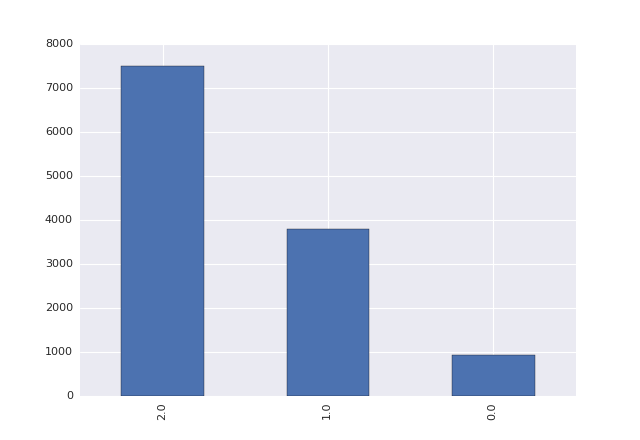

In [37]:
import matplotlib
%matplotlib nbagg
landslid3_pd.plot(kind='bar');

## run train test split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

## Begin Model analysis

### Calculate Null Accuracy

In [47]:
import time
start = time.time()

nulltime1 = %%timeit -o 1 + 2
null = y_test['LANDSLID_3'].value_counts().head(1) / len(y_test['LANDSLID_3'])
print null

end = time.time()
nulltime1 = end - start
print nulltime1

10000000 loops, best of 3: 29.7 ns per loop
2    0.613198
dtype: float64
1.5439760685


## 10-fold cross-validation with logistic regression


In [48]:
y = np.ravel(y)

In [49]:
import time
start = time.time()

logregtime1 = %%timeit -o 1 + 2
#%%memit
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X,y)
logreg_scores_mean = cross_val_score(logreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
logregtime1 = end - start
print logregtime1

10000000 loops, best of 3: 29.7 ns per loop
4.07221913338


In [50]:
print logreg_scores_mean

0.612773976257


## Naive Bayes Multinomial

In [54]:
import time
start = time.time()

from sklearn.naive_bayes import MultinomialNB
nbm = MultinomialNB()
nbm.fit(X, y)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nbm_scores = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

end = time.time()
nbmtime1 = end - start
print nbmtime1

0.380768060684


In [109]:
nbm_mean_score = nbm_scores.mean()
print nbm_mean_score

0.397677270908


## 10-fold cross-validation with K Nearest Neighbor

In [56]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9)
#scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
knn_scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print knn_scores

[ 0.68326531  0.70669935  0.69526144  0.69035948  0.70098039  0.71813725
  0.71977124  0.69199346  0.69607843  0.69526144]


In [57]:
mean_score = knn_scores.mean()
print mean_score

0.699780778978


## Search for an optimal value of K for KNN

In [58]:
# search for an optimal value of K for KNN
k_range = range(1, 31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    k_scores.append(scores.mean())
print k_scores

[0.7260860344137654, 0.65942443644124327, 0.6861371882086168, 0.68058329998666145, 0.69994417767106842, 0.69038495398159272, 0.69561164465786307, 0.6879331732693077, 0.69079425103374681, 0.68580912364945978, 0.69569521141790047, 0.69356942777110842, 0.69773742830465524, 0.69267260237428296, 0.6936519274376417, 0.68981239162331598, 0.6952873149259704, 0.69259103641456587, 0.69234593837535008, 0.68916113111911426, 0.68907956515939695, 0.69013918900893689, 0.68932379618514061, 0.69038415366146455, 0.68858796852074167, 0.68793450713618787, 0.68523869547819127, 0.68466686674669863, 0.68295284780578902, 0.68303354675203409]


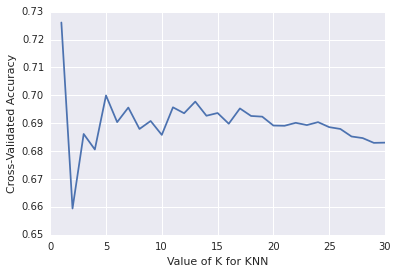

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Re-run KNN with an optimized k=30

In [60]:
import time
start = time.time()

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X,y)
knn_scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
knntime1 = end - start
print knntime1

0.852331161499


In [61]:
print knn_scores

0.683930772309


## Decision Tree - Fit a classification tree with an initial max_depth=3 on all data


In [62]:
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
scores = cross_val_score(treeclf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
treeclf.fit(X, y)
print scores.mean()

0.664897358944


## Decision Tree - search for an optimal gamma/depth for Decision Tree

In [63]:
from sklearn.tree import DecisionTreeClassifier
t_range = range(1, 100)
t_scores = []
for k in t_range:
    clf = DecisionTreeClassifier(max_depth=k)
    scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    t_scores.append(scores.mean())
print t_scores

[0.64381932773109241, 0.65288922235560887, 0.66522482326263843, 0.67061604641856742, 0.67298692810457517, 0.6731489262371616, 0.67992657062825124, 0.6949610510871016, 0.69594030945711616, 0.70582746431906096, 0.71530012004801913, 0.71832492997198882, 0.7202005468854209, 0.72412404961984789, 0.72730972388955573, 0.72632826463918898, 0.7241227824463119, 0.72910784313725485, 0.73196738695478181, 0.7324563158596773, 0.73678571428571438, 0.73278438041883409, 0.73171995464852613, 0.73482439642523667, 0.73106836067760439, 0.73041296518607457, 0.73523235961051081, 0.73351714018940917, 0.73384367080165391, 0.73245578231292519, 0.72853428037881818, 0.73008723489395755, 0.73180278778177943, 0.73082179538482051, 0.7340086701347206, 0.73253728157929854, 0.73335400826997466, 0.73155722288915581, 0.73155855675603576, 0.72935260770975052, 0.73572355608910234, 0.73041396558623439, 0.73335647592370279, 0.7281271175136721, 0.7317216219821262, 0.73515272775776974, 0.73302801120448169, 0.72845458183273326,

### Decision Tree - Plot accuracy of cross validation runs vs. values of depth

<IPython.core.display.Javascript object>


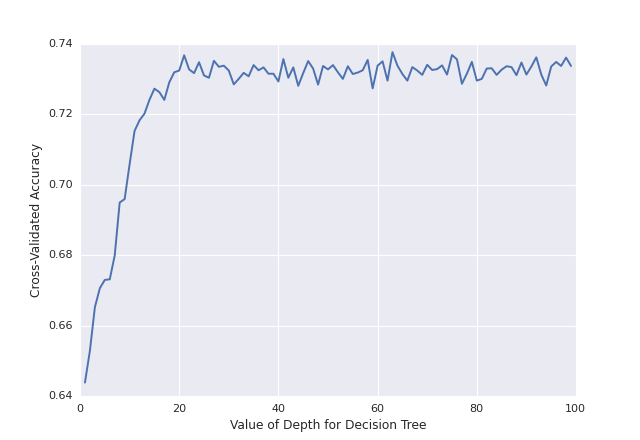

In [64]:
import matplotlib
%matplotlib nbagg
plt.plot(t_range, t_scores)
plt.xlabel('Value of Depth for Decision Tree')
plt.ylabel('Cross-Validated Accuracy')

## Decision Tree - Model optimization results:

After examining accuracy for a variety of depths, its appears that a value of ~20 for a max depth is optimal in terms of cross validation accuracy.

In [65]:
import time
start = time.time()

clftime1 = %%timeit -o 1 + 2
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=20, random_state=1)

treeclf_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
treeclf.fit(X, y)

end = time.time()
clftime1 = end - start
print clftime1

10000000 loops, best of 3: 29.7 ns per loop
2.09546113014


In [66]:
treeclf_scores_mean = treeclf_scores.mean()
print treeclf_scores_mean

0.733436708017


In [68]:
from StringIO import StringIO
tree_landslide = StringIO()

from sklearn.tree import DecisionTreeClassifier, export_graphviz
export_graphviz(treeclf, out_file=tree_landslide)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.179867 to fit



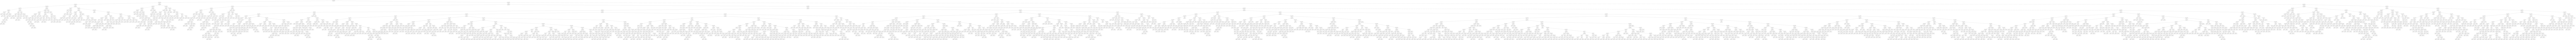

In [69]:
graph = pydot.graph_from_dot_data(tree_landslide.getvalue())  
Image(graph.create_png())

## Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier
rfreg = RandomForestClassifier()
rfreg

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [71]:
t_range = range(1, 100)
t_scores = []
for k in t_range:
    rfreg = RandomForestClassifier(n_estimators=k, random_state=42)
    rf_scores = cross_val_score(rfreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    t_scores.append(rf_scores.mean())

In [82]:
t_range = range(1, 20)
t_scores = []
for k in t_range:
    rfreg = RandomForestClassifier(n_estimators=k, random_state=42)
    rf_scores = cross_val_score(rfreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    t_scores.append(rf_scores.mean())

<IPython.core.display.Javascript object>


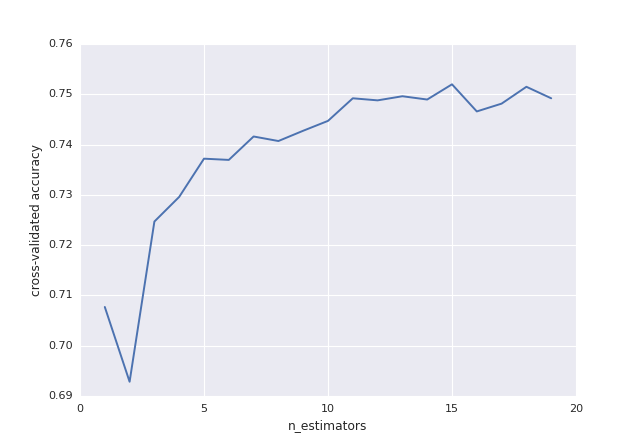

In [83]:
import matplotlib
%matplotlib nbagg
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(t_range, t_scores)
plt.xlabel('n_estimators')
plt.ylabel('cross-validated accuracy')

## Random Forest - List of values to try for max_features

In [84]:
feature_range = range(1, len(feature_cols)+1)
t_scores = []
for feature in feature_range:
    rfreg = RandomForestClassifier(n_estimators=30, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    t_scores.append(MSE_scores.mean())

<IPython.core.display.Javascript object>


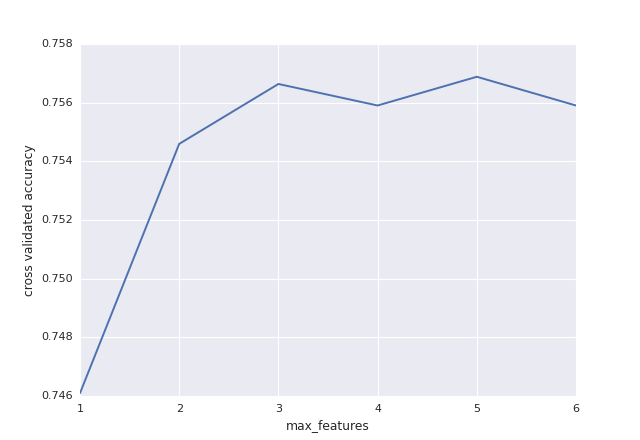

In [74]:
import matplotlib
%matplotlib nbagg
plt.plot(feature_range, t_scores)
plt.xlabel('max_features')
plt.ylabel('cross validated accuracy')

## Re-run Random Forest with optimized settings

In [85]:
import time
start = time.time()

rfreg = RandomForestClassifier(n_estimators=20, max_features=6, oob_score=True, random_state=1)
rfreg.fit(X, y)
rfscores_mean = cross_val_score(rfreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
rfregtime1 = end - start
print rfregtime1

7.54869699478


In [86]:
print rfscores_mean

0.752716486595


## Random Forest and Feature Importance

In [87]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort('importance')

,feature,importance
3,LAND_USE,0.045771
5,SLOPE_MORP,0.068376
4,LANDSLIDE1,0.116681
0,gradient_cat,0.123285
2,reacch_soi,0.309181
1,GEOLOGIC_1,0.336706


In [88]:
# compute the out-of-bag R-squared score
rfreg.oob_score_

0.75075565721754756

## Setting a threshold on which features to include?

In [89]:
# set a threshold for which features to include
print rfreg.transform(X, threshold=0.1).shape
print rfreg.transform(X, threshold='mean').shape
print rfreg.transform(X, threshold='median').shape

(12241, 4)
(12241, 2)
(12241, 3)


In [90]:
# create a new feature matrix that only includes important features
X_important = rfreg.transform(X, threshold=0.1)

In [92]:
rfreg_opt = RandomForestClassifier(n_estimators=20, max_features=4, random_state=1)
rfreg_opt.fit(X,y)
scores = cross_val_score(rfreg_opt, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

In [93]:
print scores

0.751735427504


## Bootstrap aggregation of decision tree

In [94]:
bag_scores = []
bag_range = range(1, 20)
for k in bag_range:
    bag_clf = BaggingClassifier(treeclf, n_estimators=k, max_samples=1.0, max_features=6, bootstrap = False, bootstrap_features = True, random_state=42)
    bag_clf.fit(X, y)
    bagclf_scores = cross_val_score(bag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    bag_scores.append(bagclf_scores.mean())

<IPython.core.display.Javascript object>


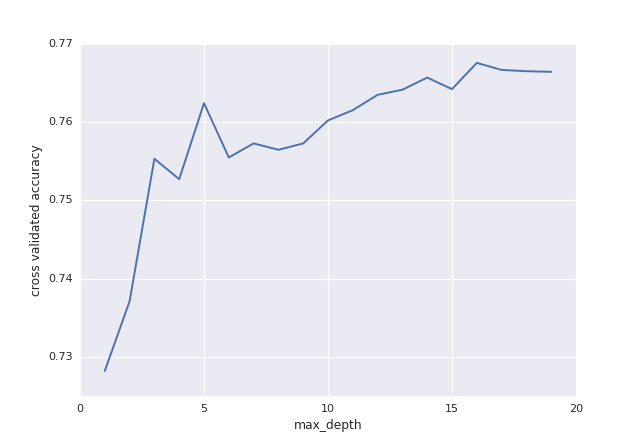

In [95]:
import matplotlib
%matplotlib nbagg
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(bag_range, bag_scores)
plt.xlabel('max_depth')
plt.ylabel('cross validated accuracy')

In [ ]:
bag_clf_scores = cross_val_score(bag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

## Re-run bootstrap aggregation Decision Tree with optimized parameters

In [96]:
import time
start = time.time()

bag_clf_opt = BaggingClassifier(treeclf, n_estimators=20, max_samples=1.0, max_features=6, bootstrap = False, bootstrap_features = True, random_state=42)
bag_clf_opt.fit(X, y)
bag_clf_scores = cross_val_score(bag_clf_opt, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
bagclftime1 = end - start
print bagclftime1

9.79126191139


In [97]:
print bag_clf_scores

0.768482726424


## Bootstrap Aggregation using Random Forest - optimize estimators

In [98]:
bag_scores = []
bag_range = range(1, 20)
for k in bag_range:
    bag_clf = BaggingClassifier(rfreg, n_estimators=k, max_samples=1.0, max_features=6, bootstrap = False, bootstrap_features = True, random_state=42)
    bag_clf.fit(X, y)
    bagrf_scores = cross_val_score(bag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    bag_scores.append(bagrf_scores.mean())

/usr/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:379: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


<IPython.core.display.Javascript object>


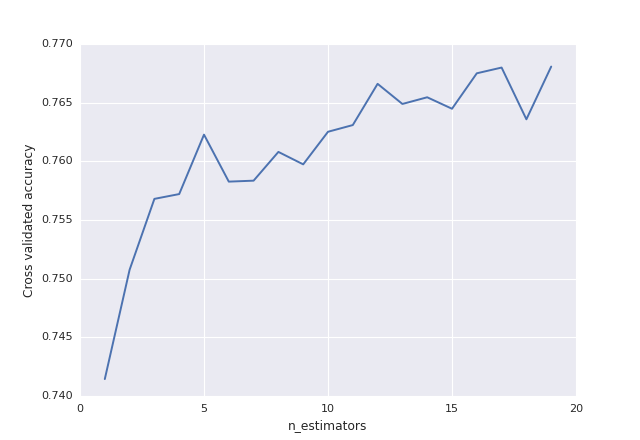

In [120]:
import matplotlib
%matplotlib nbagg
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(bag_range, bag_scores)
plt.xlabel('n_estimators')
plt.ylabel('Cross validated accuracy')

## Re-run Bootstrap Aggregation using Random Forest with optimized estimators

In [100]:
import time
start = time.time()

bag_clf_opt = BaggingClassifier(treeclf, n_estimators=20, max_samples=1.0, max_features=5, bootstrap = False, bootstrap_features = True, random_state=42)
bag_clf_opt.fit(X, y)
MSE_scores = cross_val_score(bag_clf_opt, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
bagrftime1 = end - start
print bagrftime1

7.75886893272


In [101]:
print MSE_scores

0.764970188075


In [ ]:
y = np.ravel(y)

## Time for Models

In [116]:
#time1 = [nulltime1.best, nbmtime1.best, logregtime1.best, clftime1.best, bagclftime1.best, rfregtime1.best, bagrftime1.best]
time1 = [nulltime1, nbmtime1, logregtime1, knntime1, treeclftime1, rfregtime1, bagclftime1, bagrftime1]
seriestime1 = pd.Series(time1)
print seriestime1

0    1.543976
1    0.380768
2    4.072219
3    0.852331
4    2.095461
5    7.548697
6    9.791262
7    7.758869
dtype: float64


## Cross Validation Accuracy

In [115]:
#cv1 = [null, logreg_scores_mean, mean_score, knn_scores, treeclf_scores_mean, scores, bag_clf_scores, MSE_scores]
cv1 = [null, nbm_mean_score, logreg_scores_mean, knn_scores, treeclf_scores_mean, rfscores_mean, bag_clf_scores,  MSE_scores]
seriescv1 = pd.Series(cv1)
print seriescv1

0    2    0.613198
dtype: float64
1                       0.3976773
2                        0.612774
3                       0.6839308
4                       0.7334367
5                       0.7527165
6                       0.7684827
7                       0.7649702
dtype: object


##  EXTRA: Developing a climate machine learning API

- Python <br>
- Flask Micro web framework (similar to Django but more streamlined) <br>
- uses the concept of routes to expose particular pythonic features <br>
- results in a web page, where issuing feature variables to the server returns a prediction <br>
- Future research efforts are to apply this technique to an n-geographic space to generate predictive landscapes <br>

In [106]:
import PIL
import os,sys
import numpy as np
from PIL import Image
basewidth = 1100
img = Image.open(urlopen("http://webpages.uidaho.edu/erichs/dmine-data/machine_learning_api.jpg"))
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
img.save("machine_learning_api.jpg")

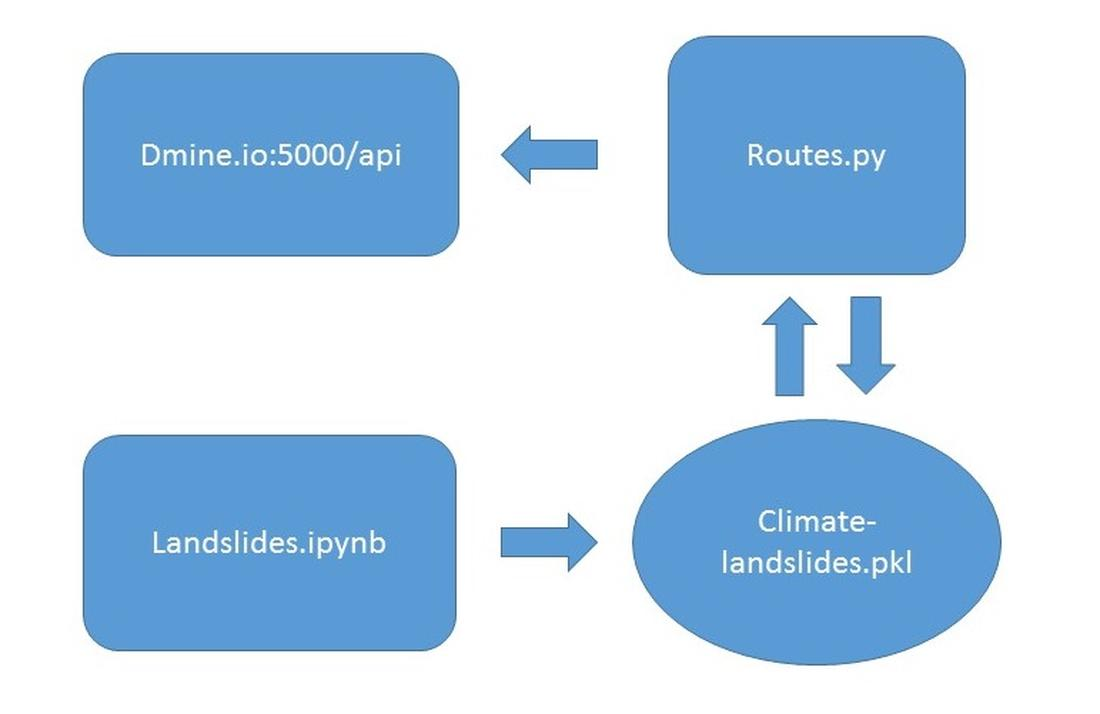

In [107]:
import os,sys
from PIL import Image
jpgfile = Image.open("machine_learning_api.jpg")
jpgfile

## Routes.py for landslides - using random forest as the pickled model

import numpy as np
#need to 'conda install flask' for this to work
from flask import Flask, abort, jsonify, request, render_template
from flask.ext.googlemaps import GoogleMaps
from flask_googlemaps import Map
import cPickle as pickle
from pymongo import MongoClient
import StringIO
import random
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

landslide_model = pickle.load(open("climate-landslide.pkl", "rb"))

app = Flask(__name__)

GoogleMaps(app)

#@app.route('/')
#def home():

@app.route('/')
def mapview():
    # creating a map in the view
    mymap = Map(
        identifier="view-side",
        lat=37.4419,
        lng=-122.1419,
        markers=[(37.4419, -122.1419)]
    )
    sndmap = Map(
        identifier="sndmap",
        lat=37.4419,
        lng=-122.1419,
        markers={'http://maps.google.com/mapfiles/ms/icons/green-dot.png':[(37.4419, -122.1419)],
                 'http://maps.google.com/mapfiles/ms/icons/blue-dot.png':[(37.4300, -122.1400)]}
    )
    return render_template('landslide.html', mymap=mymap, sndmap=sndmap)

def connect_mongo(text):
    client = MongoClient()
    db = client['mydb']
    collection = db['vload']
    b = list()
    a = list(collection.find())
    for i in range(len(a)):
        b.append(a[i][text])
        return b


@app.route('/plot',methods=['POST'])
def plot_perf_metric():

        if(request.form['submit_plot'] == "Send"):
                text = request.form['perf_metric']
                return render_template('plot.html')


@app.route('/output')
def output_plot():
    fig = Figure()
    axis = fig.add_subplot(1, 1, 1)
    b=connect_mongo(plot_perf_metric.text)
    fig = axis.plot(b)
    output = StringIO.StringIO()
    response = make_response(output.getvaluest())
    response.mimetype = 'image/png'
    fig.savefig(output)
    output.seek(0)
    return send_file(output, mimetype='image/png')


@app.route('/api', methods=['POST'])
def make_predict():
    #all kinds of error checking should go here
    data = request.get_json(force=True)
    #convert our json to a numpy array
    predict_request = [data['GEOLOGIC_1'],data['gradient_cat'],data['reacch_soi'],data['LANDSLIDE1'],data['SLOPE_MORP'],data['LAND_USE']] 
    predict_request = np.array(predict_request)
    y_hat = landslide_model.predict(predict_request)
    #return our prediction
    output = [y_hat[0]]
    return jsonify(results=output)

if __name__ == '__main__':
    app.run(host='129.101.160.58', port = 5000, debug = True)


## Run routes.py and it starts the API!

In [ ]:
url = "http://129.101.160.58:5000/api"
data = json.dumps({'GEOLOGIC_1':33552, 'gradient_cat':3, 'reacch_soi':55805, 'LANDSLIDE1':2, 'SLOPE_MORP':12,'LAND_USE':4})
r = requests.post(url, data)

print r.json()

# FINIT